# FasterRCNN

The FasterRCNN [documentation](https://github.com/pytorch/vision/blob/4d2d8bb0689fd49a469221cd3f22c21c3b715b66/torchvision/models/detection/faster_rcnn.py#L262) requires background class to be included. This is also apparent in the below notebooks:

- https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train/
- https://www.kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-train
- https://www.kaggle.com/chekoduadarsh/pytorch-beginner-code-faster-rcnn

## Imports

In [1]:
# imports
import torch
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import platform
from torch.autograd import Variable
import time
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import GeneralizedRCNNTransform
from torchvision.models.detection import  FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import glob
import os
import gc
import json
import ast
# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_from_albumentations
# numba
import numba
from numba import jit

# vis
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import ceil
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import PIL
import warnings
warnings.filterwarnings("ignore")

# Setup

In [2]:
def apply_ast(string):
    try:
        return(ast.literal_eval(string))
    except:
        return(None)

In [3]:
train = pd.read_csv('../input/id_s.csv')

In [4]:
train['boxes'] = train.boxes.apply(apply_ast)

In [5]:
to_fill = [{'x': 0, 'y': 0, 'width': 1, 'height': 1}]

In [6]:
def fill_null(x):
    if not x:
        return(to_fill)
    else:
        return(x)

In [7]:
train.boxes = train.boxes.apply(fill_null)

In [8]:
train.head(5)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,opacity_count,integer_label,human_label,file_path,image_width,image_height,image_shape,fold
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\5776db0cec75\814...,4256,3488,"(3488, 4256)",0
1,000c3a3f293f,"[{'x': 0, 'y': 0, 'width': 1, 'height': 1}]",none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,Negative for Pneumonia,C:\Users\Admin\Git\SIIM\train\ff0879eb20ed\d8a...,4256,3488,"(3488, 4256)",0
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\9d514ce429a7\228...,4256,3488,"(3488, 4256)",4
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,3,Atypical Appearance,C:\Users\Admin\Git\SIIM\train\28dddc8559b2\4d4...,4256,3488,"(3488, 4256)",4
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,Typical Appearance,C:\Users\Admin\Git\SIIM\train\dfd9fdd85a3e\491...,4256,3488,"(3488, 4256)",2


In [9]:
class Config:
    train_pcent = 0.8
    TRAIN_BS = 1
    VALID_BS = 1
    NB_EPOCHS = 20
    model = 'FasterRCNNDetector'
    reshape_size = (800, 800)
    num_classes = 4
    seed = 69
    iou_threshold = [0.5]
    mean = 0.532
    std = 0.208
    max_pixel_value = 1.0
    val_fold = 4
    save_path = 'C:\\Users\\Admin\\Git\\SIIM\\models\\FasterRCNNDetector\\'
    gradient_clipping=True

In [10]:
config_dict = {attribute: value for attribute, value in Config.__dict__.items() if '__' not in attribute }

In [11]:
mapping = {0: 'Negative for Pneumonia',
1: 'Typical Appearance',
2: 'Indeterminate Appearance',
3: 'Atypical Appearance'}

In [12]:
train_ids = train[train.fold!=Config.val_fold].id.values
valid_ids = train[train.fold==Config.val_fold].id.values

# Transformations

In [13]:
train_transform = A.Compose([
        A.RandomRotate90(p=0.1),
        A.Flip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Resize(height=800, width=800, p=1.0)],
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

valid_transform = A.Compose([A.Resize(height=800, width=800, p=1.0)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Dataset

In [14]:

class SIIM(Dataset):
    def __init__(self, image_ids, df, transforms=None):
        super().__init__()
        # image_ids
        self.image_ids = image_ids
        # random sample data
        self.df = df
        # augmentations
        self.transforms = transforms
    
    def __len__(self) -> int:
        return(len(self.image_ids))
    
    @staticmethod
    def dicom2array(path: str, voi_lut=True, fix_monochrome=True):
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        return data.astype(np.float32)
    
    def load_bbox_labels(self, image_id, shape):
        rows, cols = shape
        records = self.df[self.df['id'] == image_id]
        new_boxes = []
        for boxes in records.boxes.values:
            if boxes:
                for box in boxes:
                    frac_box = np.clip((box['x']/cols, box['y']/rows, (box['x']+box['width'])/cols,
                                      (box['y']+box['height'])/rows), 0, 1)
                    converted = convert_bbox_from_albumentations(bbox=frac_box, 
                                                 target_format='pascal_voc', 
                                                 rows=rows, cols=cols, 
                                                 check_validity=True)
                    new_boxes.append(converted)
        labels = [records['integer_label'].values[0]] * len(boxes)
        return(new_boxes, labels)
        
    def __getitem__(self, idx: int):
        # retrieve idx data
        image_id = self.image_ids[idx]
        # get path
        image_path = self.df[self.df['id'] == image_id].file_path.values[0]
        # get image
        image = self.dicom2array(image_path)
        # get boxes and labels
        boxes, labels = self.load_bbox_labels(image_id, image.shape)
        if self.transforms:
            tform = self.transforms(image=image, 
                              bboxes=boxes, 
                              labels=labels)
            image = tform['image']
            target = {'boxes': torch.tensor(tform['bboxes']), 
                      'labels': torch.tensor(tform['labels'])}
            # 1 Channel vs 3 Channel?
            image = np.dstack((image, image, image))
            return(torch.tensor(image).permute(2, 0, 1), target, image_id)
            
        return image, boxes, image_id

In [15]:
dataset = SIIM(image_ids=train_ids, df=train, transforms=train_transform)

In [16]:
image, target, image_id = dataset[5]

In [17]:
target

{'boxes': tensor([[ 77.0833, 207.7582, 330.7292, 756.0413],
         [519.2708, 246.7638, 763.0209, 755.0746]], dtype=torch.float64),
 'labels': tensor([1, 1])}

In [18]:
def show_one(image, target):
    print(target)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    boxes = target['boxes'].numpy().astype(np.int32)
    image = image.squeeze(0).numpy()
    if len(boxes)>0:
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            startX, endX, startY, endY = int(xmin), int(xmax), int(ymin), int(ymax)
            color = (0, 255, 0)
            thickness = 1
            image = cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.bone)
    plt.show()

In [19]:
BOX_COLOR = (1, 0, 0) # Red

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)  
    return img


def visualize(image, bboxes):
    img = image.copy()
    for box in bboxes:
        img = visualize_bbox(img, box)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img, cmap=plt.bone())
    plt.show()

Showing image with id: 000c3a3f293f
{'boxes': tensor([[0.0000, 0.0000, 0.2825, 0.3448]], dtype=torch.float64), 'labels': tensor([0])}


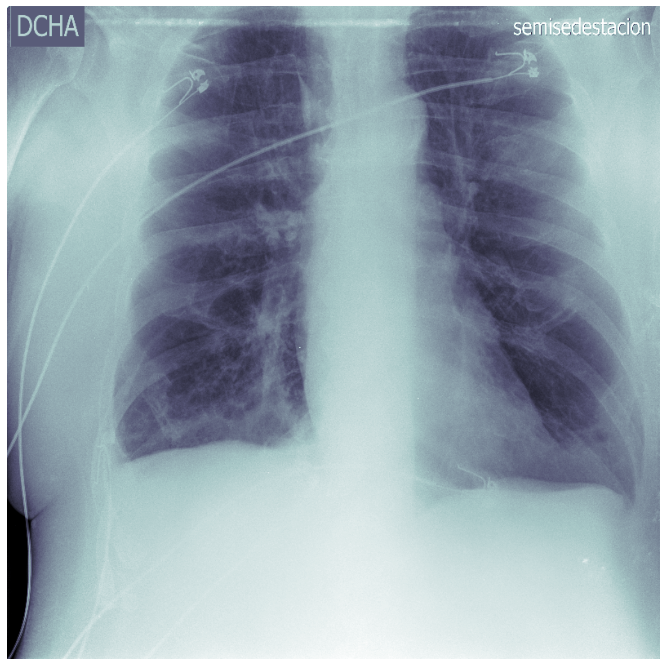

--------------------------------------------------
Showing image with id: 0022227f5adf
{'boxes': tensor([[487.1361, 160.1593, 585.7663, 286.0448]], dtype=torch.float64), 'labels': tensor([2])}


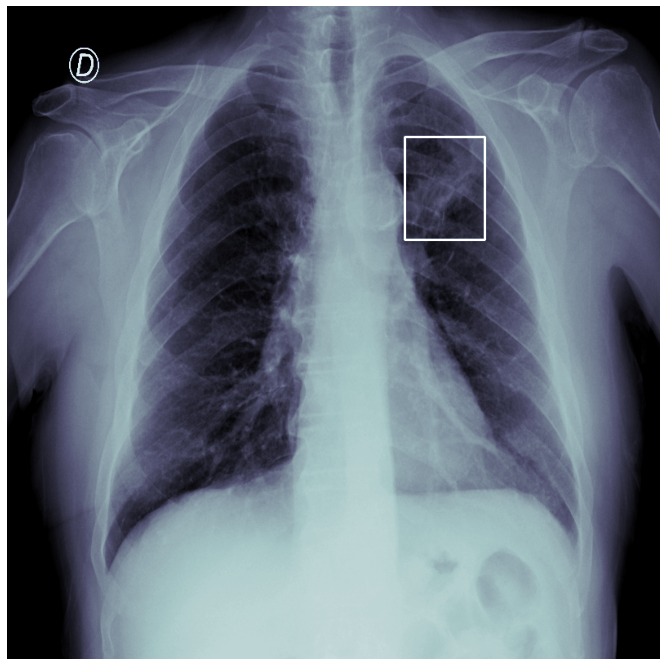

--------------------------------------------------
Showing image with id: 002e9b2128d0
{'boxes': tensor([[ 77.0833, 207.7582, 330.7292, 756.0413],
        [519.2708, 246.7638, 763.0209, 755.0746]], dtype=torch.float64), 'labels': tensor([1, 1])}


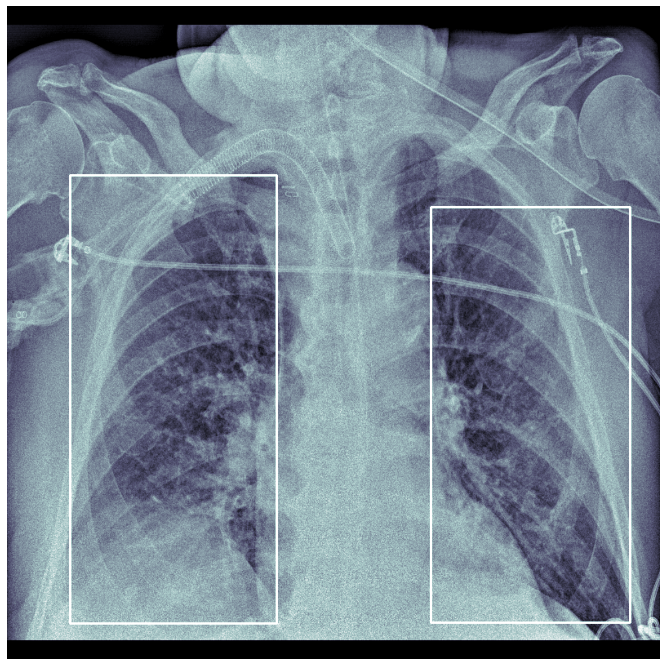

--------------------------------------------------
Showing image with id: 0044e449aae1
{'boxes': tensor([[190.6667, 480.6171, 478.6667, 737.6100],
        [297.3333, 129.1737, 462.6667, 313.6815]], dtype=torch.float64), 'labels': tensor([1, 1])}


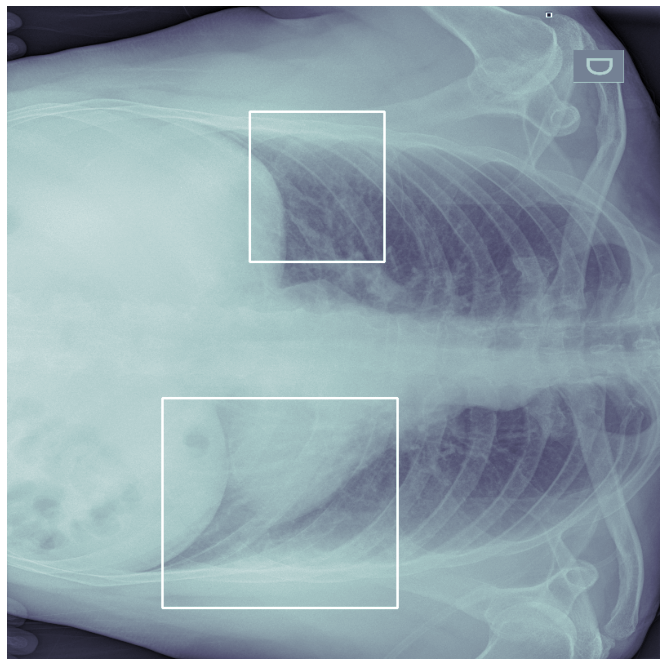

--------------------------------------------------
Showing image with id: 004cbd797cd1
{'boxes': tensor([[137.7502, 312.9560, 368.5895, 631.4284],
        [433.0322, 299.4859, 668.6807, 642.0121]], dtype=torch.float64), 'labels': tensor([1, 1])}


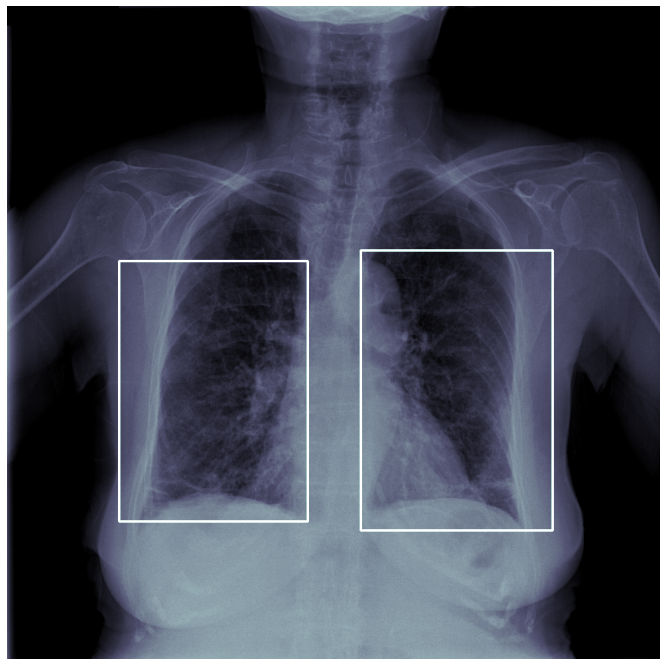

--------------------------------------------------


In [20]:
for i, (image, target, idx) in enumerate(dataset):
    if i % 2 ==0:
        continue
    if i > 10:
        break
    print(f'Showing image with id: {idx}')
    print(target)
    visualize(image.numpy()[0,:,:], target['boxes'].numpy())
    print('-'*50)

# Model

In [21]:
class FasterRCNNDetector(torch.nn.Module):
    def __init__(self, pretrained=True, **kwargs):
        super(FasterRCNNDetector, self).__init__()
        # load pre-trained model incl. head
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained, 
                                                                          pretrained_backbone=pretrained)
        # get number of input features for the classifier custom head
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

    def forward(self, images, targets=None):
        return self.model(images, targets)

# Collate

In [22]:
def collate_fn(batch):
    images, targets, idx = tuple(zip(*batch))
    return(tuple((torch.stack(images).float(), targets, idx)))
    #return (tuple(zip(*batch))

# Image Precision

In [23]:
# numba
import numba
from numba import jit
import numpy as np


def image_precision(boxes, scores, gt_boxes):
    '''
    https://www.kaggle.com/pestipeti/competition-metric-details-script
    '''

    @jit(nopython=True)
    def calculate_iou(gt, pr, form='pascal_voc') -> float:
        """Calculates the Intersection over Union.
        Args:
            gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
            pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
            form: (str) gt/pred coordinates format
                - pascal_voc: [xmin, ymin, xmax, ymax]
                - coco: [xmin, ymin, w, h]
        Returns:
            (float) Intersection over union (0.0 <= iou <= 1.0)
        """
        if form == 'coco':
            gt = gt.copy()
            pr = pr.copy()

            gt[2] = gt[0] + gt[2]
            gt[3] = gt[1] + gt[3]
            pr[2] = pr[0] + pr[2]
            pr[3] = pr[1] + pr[3]

        # Calculate overlap area
        dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
        
        if dx < 0:
            return 0.0
        
        dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

        if dy < 0:
            return 0.0

        overlap_area = dx * dy

        # Calculate union area
        union_area = (
                (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
                (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
                overlap_area
        )

        return overlap_area / union_area

    @jit(nopython=True)
    def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
        """Returns the index of the 'best match' between the
        ground-truth boxes and the prediction. The 'best match'
        is the highest IoU. (0.0 IoUs are ignored).
        Args:
            gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
            pred: (List[Union[int, float]]) Coordinates of the predicted box
            pred_idx: (int) Index of the current predicted box
            threshold: (float) Threshold
            form: (str) Format of the coordinates
            ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.
        Return:
            (int) Index of the best match GT box (-1 if no match above threshold)
        """
        best_match_iou = -np.inf
        best_match_idx = -1

        for gt_idx in range(len(gts)):
            
            if gts[gt_idx][0] < 0:
                # Already matched GT-box
                continue
            
            iou = -1 if ious is None else ious[gt_idx][pred_idx]

            if iou < 0:
                iou = calculate_iou(gts[gt_idx], pred, form=form)
                
                if ious is not None:
                    ious[gt_idx][pred_idx] = iou

            if iou < threshold:
                continue

            if iou > best_match_iou:
                best_match_iou = iou
                best_match_idx = gt_idx

        return best_match_idx

    @jit(nopython=True)
    def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
        """Calculates precision for GT - prediction pairs at one threshold.
        Args:
            gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
            preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
                sorted by confidence value (descending)
            threshold: (float) Threshold
            form: (str) Format of the coordinates
            ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.
        Return:
            (float) Precision
        """
        n = len(preds)
        tp = 0
        fp = 0
        
        # for pred_idx, pred in enumerate(preds_sorted):
        for pred_idx in range(n):

            best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                                threshold=threshold, form=form, ious=ious)

            if best_match_gt_idx >= 0:
                # True positive: The predicted box matches a gt box with an IoU above the threshold.
                tp += 1
                # Remove the matched GT box
                gts[best_match_gt_idx] = -1

            else:
                # No match
                # False positive: indicates a predicted box had no associated gt box.
                fp += 1

        # False negative: indicates a gt box had no associated predicted box.
        fn = (gts.sum(axis=1) > 0).sum()

        return tp / (tp + fp + fn)


    @jit(nopython=True)
    def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
        """Calculates image precision.
        The mean average precision at different intersection over union (IoU) thresholds.
        Args:
            gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
            preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
                sorted by confidence value (descending)
            thresholds: (float) Different thresholds
            form: (str) Format of the coordinates
        Return:
            (float) Precision
        """
        n_threshold = len(thresholds)
        image_precision = 0.0
        
        ious = np.ones((len(gts), len(preds))) * -1
        # ious = None

        for threshold in thresholds:
            precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                        form=form, ious=ious)
            image_precision += precision_at_threshold / n_threshold

        return image_precision

    preds_sorted_idx = np.argsort(scores)[::-1]
    preds_sorted_boxes = boxes[preds_sorted_idx]
    return(calculate_image_precision(preds_sorted_boxes,
                                            gt_boxes,
                                            thresholds=[0.4, 0.5, 0.6],
                                            form='pascal_voc'))


# Logging

In [24]:
class Logman(object):
    """
    Json data should save as follows:
    
    {'type': hyper, 'model':?, 'optim': ?, 'model': ?, 'train_len': ?, 'val_len': ?, 'device': ? ...etc...}
    {'type': train, 'epoch': num, 'batch': num, 'loss': num, ...etc...}
    {'type': val, 'epoch': num, 'batch': num, 'loss': num, 'metric': num ...etc...}
    {'type': final, 'epochs': num, 'batches': num, 'final_loss': num, 'final_metric': num ...etc...}
    
    """
    def __init__(self, hyper, save_path='./', save_name='logs'):
        #load
        self.hyper = hyper
        self.save_path = save_path
        self.save_name = save_name
        # assertions
        assert self.hyper['model']
        # init store
        self.store = self.hyper
        self.store['logs'] = []
        # save empty logs
        self.save_logs()
        
    def save_logs(self):
        """
        The current implementation does not append or concatenate current file
        but instead save on top of current file with large dictionary.
        """
        with open(os.path.join(self.save_path, self.save_name)+'.json','w') as file:
            json.dump(self.store, file, indent = 4)
            file.close()
            
    def log(self, data):
        """
        Takes in any input data of form dict.
        Handles data by key 'type'.
        Sends to relevant method.
        """
        if data:
            # first log
            if not self.store['logs']:
                self.store['logs'] = [data]
            else:
                # check for final
                if data['type'] == 'final':
                    self.finalise(data)
                else:
                    # append data to data key in store
                    self.store['logs'].append(data)
        else:
            # error
            self.store['logs'].append({'type': 'error', 'reason': 'No data present'})
    
    def finalise(self, data):
        """
        Finalise logs, send final parameters to dict.
        Save logs
        """
        self.store.update({k: v for k, v in data.items() if (k != 'type' and k != 'model')})
        self.save_logs()

# Trainer

In [25]:
def save(model, optim, scheduler, epoch, final_loss, final_prec):
    save_path = 'C:\\Users\\Admin\\Git\\SIIM-FISABIO-RSNA-COVID-19-Detection\\out\\'
    os.makedirs(save_path, exist_ok=True)
    # save model
    model.eval()
    torch.save({
        'model_state_dict': model.state_dict(), #'model_state_dict': self.model.model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': final_loss,
        'image_precision': final_prec,
        'epoch': epoch,
        
    }, save_path+'epoch_{epoch}.pth'.format(epoch=epoch))

In [26]:
def OD(model, dataloaders, optimiser, scheduler, device, metric, logman, loss=None):
    def train_one_cycle(model, dataloader, optimiser, epoch, device):
        """
        Run one epoch of training, backpropogation and optimisation.
        """
        # model train mode
        model.train()

        batch_size = Config.TRAIN_BS
        len_dataset = len(dataloader.dataset)
        step = math.ceil(len_dataset / batch_size)
        # progress bar
        train_prog_bar = tqdm(dataloader, total=step)
        running_loss = 0

        with torch.set_grad_enabled(True):
            for batch_num, (images, targets, idx) in enumerate(train_prog_bar):
                # zero gradient optim
                optimiser.zero_grad()
                # send to devices
                images = images.to(device)
                tg = [{k: v.to(device) for k, v in t.items()} for t in targets]
                # get outputs
                losses = model(images, tg)
                # training
                train_loss = sum(loss for loss in losses.values())

                # Backpropogation
                train_loss.backward()
                # gradient clipping
                if Config.gradient_clipping==True:
                    torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
                # optimiser step
                optimiser.step()
                # For averaging and reporting later
                running_loss += train_loss.item()
                # logging
                if logman:
                    logman.log({'type': 'train', 
                                'epoch': epoch, 
                                'batch': batch_num, 
                                'loss': train_loss.item()
                            })
                # show the current loss to the progress bar
                train_pbar_desc = f'loss: {train_loss.item():.4f}'
                train_prog_bar.set_description(desc=train_pbar_desc)

            # average the running loss over all batches and return
            train_running_loss = running_loss / step
            print(f"Final Training Loss: {train_running_loss:.4f}")

            # free memory
            images, tg, losses, train_loss = None, None, None, None
            del images, tg, losses, train_loss
            # free up cache
            torch.cuda.empty_cache()
            gc.collect()
            return(train_running_loss)

    def val_one_cycle(model, dataloader, optimiser, epoch, device, metric):
        """
            Runs one epoch of prediction.
            In model.train() mode, model(images)  is returning losses.
            We are using model.eval() mode --> it will return boxes and scores.
        """
        model.eval()
        batch_size = Config.VALID_BS
        len_dataset = len(dataloader.dataset)
        step = math.ceil(len_dataset / batch_size)
        valid_prog_bar = tqdm(dataloader, total=step)
        running_prec = 0
        with torch.no_grad():
            for batch_num, (images, targets, idx) in enumerate(valid_prog_bar):
                # send to devices
                images = images.to(device)
                # get predictions
                outputs = model(images)
                # get metric
                for i, image in enumerate(images):
                    gt_boxes = targets[i]['boxes'].data.cpu().numpy()
                    boxes = outputs[i]['boxes'].data.cpu().numpy()
                    scores = outputs[i]['scores'].detach().cpu().numpy()
                    precision = metric(boxes, scores, gt_boxes)
                    running_prec += precision
                    # logging
                    if logman:
                        logman.log({'type': 'val', 
                                    'epoch': epoch, 
                                    'batch': batch_num, 
                                    'image_precision': precision,
                                })
                    # Show the current metric
                    valid_pbar_desc = f"Current Precision: {precision:.4f}"
                    valid_prog_bar.set_description(desc=valid_pbar_desc)
                    running_prec += precision

            final_prec = running_prec / step      
            print(f"Validation metric: {final_prec:.4f}")
            # Free up memory
            images, outputs, gt_boxes, boxes, scores, precision = None, None, None, None, None, None
            del images, outputs, gt_boxes, boxes, scores, precision
            torch.cuda.empty_cache()
            gc.collect()
            return(final_prec)


    def train(model, dataloaders, optimiser, scheduler, device, metric):
        num_epochs = Config.NB_EPOCHS
        for epoch in range(num_epochs):
            # train
            final_loss = train_one_cycle(model, dataloaders['train'],
                            optimiser, epoch, device)
            # val
            final_prec = val_one_cycle(model, dataloaders['val'],
                        optimiser, epoch, device, metric)
            # scheduler
            if scheduler:
                scheduler.step()
            save(model, optimiser, scheduler, epoch, final_loss, final_prec)
        # end logging
        logman.log({'type': 'final'})

    train(model, dataloaders, optimiser, scheduler, device, metric)

In [27]:
def get_device():
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        return torch.device('cuda:0')
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        return torch.device('cpu')

In [28]:
def sgd(parameters, lr=0.001, momentum=0.9, weight_decay=0, nesterov=True, **_):
    return(optim.SGD(parameters, lr=lr, momentum=momentum, weight_decay=weight_decay,
                     nesterov=nesterov))

def step(optimizer, last_epoch, step_size=80, gamma=0.1, **_):
    return lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma, last_epoch=last_epoch)

# Cycle

In [ ]:
DEVICE = get_device()
# get elements
model = FasterRCNNDetector().to(DEVICE)
optimiser = sgd(model.parameters())
scheduler = step(optimiser, -1)
metric = image_precision
loop = OD
loss = None
logman = Logman(config_dict, 'C:\\Users\\Admin\\Git\\SIIM-FISABIO-RSNA-COVID-19-Detection\\out')
######################################################################
train_dataset = SIIM(image_ids=train_ids, df=train, transforms=train_transform)
valid_dataset = SIIM(image_ids=valid_ids, df=train, transforms=valid_transform)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=Config.TRAIN_BS)  
valid_dataloader = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=Config.VALID_BS)
######################################################################
dataloaders = {'train': train_dataloader, 'val': valid_dataloader}
# main training loop
loop(model, dataloaders, optimiser, scheduler, DEVICE, metric, logman, loss)

[INFO] Using GPU: GeForce GTX 970



loss: 0.6515: 100%|██████████| 4874/4874 [50:07<00:00,  1.62it/s]  


Final Training Loss: 0.3167


Current Precision: 0.0247: 100%|██████████| 1218/1218 [38:23<00:00,  1.89s/it]


Validation metric: 0.0627


loss: 0.7038: 100%|██████████| 4874/4874 [50:43<00:00,  1.60it/s]  


Final Training Loss: 0.2967


Current Precision: 0.0302: 100%|██████████| 1218/1218 [41:23<00:00,  2.04s/it]


Validation metric: 0.0738


loss: 0.6329: 100%|██████████| 4874/4874 [51:05<00:00,  1.59it/s]  


Final Training Loss: 0.2890


Current Precision: 0.0476: 100%|██████████| 1218/1218 [44:45<00:00,  2.21s/it] 


Validation metric: 0.0762


loss: 0.5280: 100%|██████████| 4874/4874 [52:18<00:00,  1.55it/s]  


Final Training Loss: 0.2812


Current Precision: 0.0476: 100%|██████████| 1218/1218 [48:48<00:00,  2.40s/it] 


Validation metric: 0.0706


loss: 0.5824: 100%|██████████| 4874/4874 [53:35<00:00,  1.52it/s]  


Final Training Loss: 0.2733


Current Precision: 0.0270: 100%|██████████| 1218/1218 [53:11<00:00,  2.62s/it] 


Validation metric: 0.0691


loss: 0.5703: 100%|██████████| 4874/4874 [55:08<00:00,  1.47it/s]  


Final Training Loss: 0.2643


Current Precision: 0.0513: 100%|██████████| 1218/1218 [58:10<00:00,  2.87s/it] 


Validation metric: 0.0748


loss: 0.5658: 100%|██████████| 4874/4874 [56:48<00:00,  1.43it/s]  


Final Training Loss: 0.2520


Current Precision: 0.0455: 100%|██████████| 1218/1218 [1:03:44<00:00,  3.14s/it]


Validation metric: 0.0811


loss: 0.4919: 100%|██████████| 4874/4874 [59:13<00:00,  1.37it/s]  


Final Training Loss: 0.2407


Current Precision: 0.0392: 100%|██████████| 1218/1218 [1:10:22<00:00,  3.47s/it]


Validation metric: 0.0538


loss: 0.6290: 100%|██████████| 4874/4874 [1:01:11<00:00,  1.33it/s]


Final Training Loss: 0.2300


Current Precision: 0.0593: 100%|██████████| 1218/1218 [1:16:59<00:00,  3.79s/it]


Validation metric: 0.0922


loss: 0.5238: 100%|██████████| 4874/4874 [1:03:20<00:00,  1.28it/s]


Final Training Loss: 0.2218


Current Precision: 0.1000:  99%|█████████▉| 1210/1218 [1:22:25<00:30,  3.77s/it]